In [1]:
import argparse
import copy
import json
import os
from os.path import join
import sys
import matplotlib.image
from tqdm import tqdm
# load the setting.json to argparse.namespace
def parse(args=None):
    """ load config from the setting.json """
    with open(join('./setting.json'), 'r') as f:
        args_attack = json.load(f, object_hook=lambda d: argparse.Namespace(**d))
    return args_attack

args_attack = parse()
print(args_attack.global_settings)
print(args_attack.jpeg)

Namespace(attr_path='./data/list_attr_celeba.txt', batch_size=8, data_path='./data/img_align_celeba', gpu=1, img_size=256, num_test=202496, results_path='/data/huanghao/disrupting-deepfakes-results/', save_model_dir='perturbation_save_dir', universal_perturbation_path='./perturbation.pt')
Namespace(quality=50)


In [2]:
def print_network(model, name):
    """Print out the network information."""
    num_params = 0
    for p in model.parameters():
        num_params += p.numel()
    print(model)
    print(name)
    print("The number of parameters: {}".format(num_params))
    
def load_model_weights(model, path):
        pretrained_dict = torch.load(path, map_location=lambda storage, loc: storage)
        model_dict = model.state_dict()

        # 1. filter out unnecessary keys
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if 'preprocessing' not in k}
        # 2. overwrite entries in the existing state dict
        model_dict.update(pretrained_dict)
        # 3. load the new state dict
        model.load_state_dict(pretrained_dict, strict=False)
        
############ LOAD THE NETWORK TO GPU ################
import torch
model_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

############# INITIALIZE THE NETWORK ###############    
from stargan.model import Generator
config = args_attack.stargan
stargan_model = Generator(
    config.g_conv_dim,
    config.c_dim,
    config.g_repeat_num
)
print_network(stargan_model, 'StarGAN')
stargan_model.to(model_device)

############# LOAD THE PARAMETER ###################
import os 
resume_iters = 200000
G_path = os.path.join(config.model_save_dir, f'{resume_iters}-G.ckpt')
load_model_weights(stargan_model, G_path)

Generator(
  (main): Sequential(
    (0): Conv2d(8, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ResidualBlock(
      (main): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), paddi

In [3]:
# load the compress_model & decompress_model
from DiffJPEG.modules import compress_jpeg, decompress_jpeg
from DiffJPEG.utils import diff_round, quality_to_factor, y_table, c_table
from torchvision import transforms as T
quality = args_attack.jpeg.quality
compress_network = compress_jpeg(factor = quality_to_factor(quality))
compress_network = compress_network.to(model_device)
decompress_network = decompress_jpeg(
    height = 256, 
    width = 256, 
    factor = quality_to_factor(quality))
decompress_network = decompress_network.to(model_device)

In [4]:
def create_labels(c_org, c_dim=5, dataset='CelebA', selected_attrs=None):
    """Generate target domain labels for debugging and testing."""
    # Get hair color indices.
    if dataset == 'CelebA':
        hair_color_indices = []
        for i, attr_name in enumerate(selected_attrs):
            if attr_name in ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair']:
                hair_color_indices.append(i)

    c_trg_list = []
    for i in range(c_dim):
        c_trg = c_org.clone()
        if i in hair_color_indices:  # Set one hair color to 1 and the rest to 0.
            c_trg[:, i] = 1
            for j in hair_color_indices:
                if j != i:
                    c_trg[:, j] = 0
        else:
            c_trg[:, i] = (c_trg[:, i] == 0)  # Reverse attribute value.

        c_trg_list.append(c_trg.to(model_device))
    return c_trg_list
def modify_transform_domain(y_cb_cr, y_cb_cr_indicator, y_grad_sign):
    ret = y_cb_cr.clone().detach_()
    for batches in range(y_cb_cr.shape[0]):
        for blocks in range(y_cb_cr.shape[1]):
            a = y_cb_cr[batches, blocks,:, :]
            _, idx = torch.sort(a.flatten())
            for i in idx[:k_importance]:
                if y_grad_sign[batches, blocks, i//8, i%8] == 1:
                    ret[batches, blocks, i//8, i%8] = torch.round(y_cb_cr[batches, blocks, i//8, i%8]) + 1 
#                 else:
#                     ret[batches, blocks, i//8, i%8] = torch.round(y_cb_cr[batches, blocks, i//8, i%8])
    return ret
## the output of the stargan is (-1, 1) and don't forget trans it to (0, 1)
def denorm(img):
    img = (img + 1)/2
    return img.clamp_(0, 1)

In [5]:
import torch.nn as nn
epsilon = args_attack.attacks.epsilon
loss_fn = nn.L1Loss().to(model_device) # substitute the loss function.

In [7]:
# propress the CelebA dataset...
from data import CelebA
# load the attribute from the attgan setting.json@args.attrs
with open(join('./AttGAN/output', args_attack.AttGAN.attgan_experiment_name, 'setting.txt'), 'r') as f:
        args = json.load(f, object_hook=lambda d: argparse.Namespace(**d))
dataset = CelebA(
    args_attack.global_settings.data_path, 
    args_attack.global_settings.attr_path,
    args_attack.global_settings.img_size,
    'train',
    args.attrs,
    args_attack.stargan.selected_attrs
)
data_loader = iter(dataset)

Finished preprocessing the CelebA dataset...


- img.shape:	 torch.Size([3, 256, 256]) 
- attribute:	 tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1]) 
- original label:	 tensor([[0., 1., 0., 0., 1.]])
The original picture from CelebA dataset...


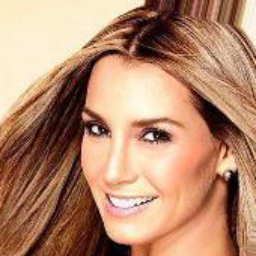

In [8]:
try:
    img_a, att_a, c_org = next(data_loader)
except:
    data_loader = iter(dataset)
    img_a, att_a, c_org = next(data_loader)
c_org = torch.unsqueeze(c_org, 0)
######## show image & print attribute #######
print("- img.shape:\t",img_a.shape, "\n- attribute:\t", att_a, "\n- original label:\t", c_org)
from torchvision import transforms as T
from PIL import Image
img = T.ToPILImage()(img_a)
print("The original picture from CelebA dataset...")
img

In [9]:
# img_a = img_a + perturbation
img_a = torch.unsqueeze(img_a, 0)
x_real = img_a.to(model_device)
c_trg_list = create_labels(c_org, config.c_dim, config.dataset, config.selected_attrs)
c_trg_list

[tensor([[1., 0., 0., 0., 1.]], device='cuda:0'),
 tensor([[0., 1., 0., 0., 1.]], device='cuda:0'),
 tensor([[0., 0., 1., 0., 1.]], device='cuda:0'),
 tensor([[0., 1., 0., 1., 1.]], device='cuda:0'),
 tensor([[0., 1., 0., 0., 0.]], device='cuda:0')]

PSNR: 27.92932229878516
SSIM: 0.9537916729216944
The ADV-IMAGE using the jpeg-resistant method


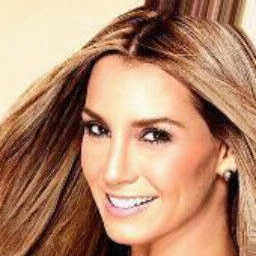

In [25]:
import numpy as np
from torchvision.utils import save_image
global valid_label
iterations = 15
alpha = 0.2
up_beta = 0.020
down_beta = 0.015
momentum_decay = 0.70
y_cumulative_gradient = None
cb_cumulative_gradient = None
cr_cumulative_gradient = None
torch.autograd.set_detect_anomaly(True)
for idx, c_trg in enumerate(c_trg_list):
    if idx!=0:
        continue
    with torch.no_grad():
        x_real_mode = x_real.clone().detach_()
        x_real_mode[0] = T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))(x_real_mode[0])
        gen_noattack, gen_noattack_feats = stargan_model(x_real_mode, c_trg) 
    
    y_nat ,cb_nat, cr_nat = compress_network(x_real)
    y = y_nat.clone().detach_() + torch.tensor(np.random.uniform(-epsilon, epsilon, y_nat.shape).astype('float32')).to(model_device)
    cb = cb_nat.clone().detach()
    cr = cr_nat.clone().detach()
    
    for k in range(iterations):
        y.requires_grad = True
        decompress_network.zero_grad()
        stargan_model.zero_grad()
        x_jpeg = decompress_network(y, cb, cr)
        loss_L_k = loss_fn(x_jpeg, x_real)
        # one of the variables needed for gradient computation has been modified by an inplace operation
        x_jpeg_mode = x_jpeg.clone()
        x_jpeg_mode[0] = T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))(x_jpeg_mode[0])
        output, feats = stargan_model(x_jpeg_mode, c_trg)
        distortion_loss = loss_fn(output, gen_noattack)
        loss = alpha * loss_L_k + distortion_loss
        loss.backward()
        y_grad = y.grad
        y_cumulative_gradient = y_grad/torch.norm(y_grad, 1) if y_cumulative_gradient is None else momentum_decay * y_cumulative_gradient + y_grad/torch.norm(y_grad,1)
        
        y_ = y + y_cumulative_gradient.sign() * up_beta

        y_ = torch.where(y_ < torch.round(y), torch.round(y), y_)
        y_ = torch.where(y_ > torch.round(y)+1, torch.round(y)+1, y_)
        y = y_.clone().detach_()
        
    decompress_network.zero_grad()
    stargan_model.zero_grad()
    X_adv = decompress_network(y, cb, cr)
    sample_path = os.path.join(f'result/adv_images.jpg')
    save_image(X_adv.data.cpu(), sample_path, nrow=1, padding=0)
    valid_label = c_trg
    break
x_adv_img = T.ToPILImage()(X_adv[0].cpu())
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
print(f"PSNR: {compare_psnr(X_adv[0].cpu().detach().numpy(), x_real[0].cpu().numpy())}")
print(f"SSIM: {compare_ssim(X_adv[0].cpu().detach().numpy(), x_real[0].cpu().numpy(), win_size = 3, multichannel=True)}")
print("The ADV-IMAGE using the jpeg-resistant method")
x_adv_img            

Deepfake picture(original image -> stargan)


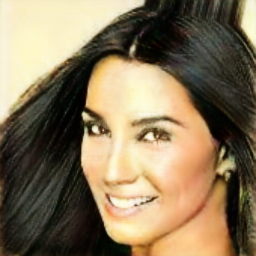

In [26]:
gen_noattack_ = denorm(gen_noattack)
gen_noattack_img = T.ToPILImage()(gen_noattack_[0].cpu())
print("Deepfake picture(original image -> stargan)")
gen_noattack_img

Deepfake picture(adv_image_before_jpeg -> stargan)


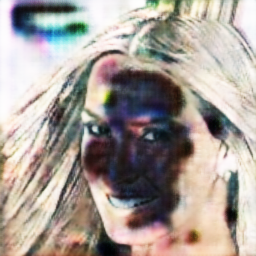

In [27]:
x_adv = torch.squeeze(X_adv)
x_adv = T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))(x_adv)
x_adv = torch.unsqueeze(x_adv, 0)
output_adv, feats = stargan_model(x_adv, c_trg)
output_adv_ = denorm(output_adv)
output_adv_img = T.ToPILImage()(output_adv_[0].cpu())
print("Deepfake picture(adv_image_before_jpeg -> stargan)")
output_adv_img

In [28]:
mask = torch.abs(gen_noattack - x_real)
mask = mask[0,0,:,:] + mask[0,1,:,:] + mask[0,2,:,:]
mask[mask>0.5] = 1
mask[mask<0.5] = 0
l1_error = torch.nn.functional.l1_loss(output_adv, gen_noattack)
l2_error = torch.nn.functional.mse_loss(output_adv, gen_noattack)
l0_error = (output_adv - gen_noattack).norm(0)
min_dist = (output_adv - gen_noattack).norm(float('-inf'))
sota_error = ((output_adv*mask - gen_noattack*mask)**2).sum() / (mask.sum()*3)
print(f"""stargan images:
\t- L1 error: {l1_error}.
\t- L2 error: {l2_error}.
\t- L0 error: {l0_error}.
\t- L_-inf error: {min_dist}.""",
f'\n\t- CMUA_error: {sota_error}. '+ ('exceed' if sota_error > 0.05 else 'under') + ' (reference value: 0.05)'
)

stargan images:
	- L1 error: 0.8926195502281189.
	- L2 error: 1.0402908325195312.
	- L0 error: 196608.0.
	- L_-inf error: 5.364418029785156e-07. 
	- CMUA_error: 1.0512399673461914. exceed (reference value: 0.05)


Deepfake picture(adv_image_after_jpeg -> stargan)


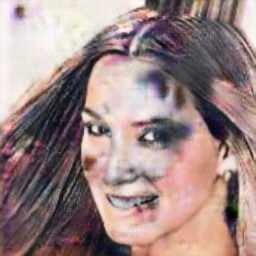

In [29]:
from PIL import Image
from torchvision import transforms
sample_path = 'result/adv_images.jpg'
tf = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
valid_image = tf(Image.open(sample_path))
valid_image = valid_image.to(model_device)
valid_image = torch.unsqueeze(valid_image, 0)
with torch.no_grad():
    adv_attack, _ = stargan_model(valid_image, valid_label)   
adv_attack_ = denorm(adv_attack)
adv_attack_img = T.ToPILImage()(adv_attack_[0].cpu())
print("Deepfake picture(adv_image_after_jpeg -> stargan)")
adv_attack_img

In [30]:
mask = torch.abs(gen_noattack - x_real)
mask = mask[0,0,:,:] + mask[0,1,:,:] + mask[0,2,:,:]
mask[mask>0.5] = 1
mask[mask<0.5] = 0
l1_error = torch.nn.functional.l1_loss(adv_attack, gen_noattack)
l2_error = torch.nn.functional.mse_loss(adv_attack, gen_noattack)
l0_error = (adv_attack - gen_noattack).norm(0)
min_dist = (adv_attack - gen_noattack).norm(float('-inf'))
sota_error = ((adv_attack*mask - gen_noattack*mask)**2).sum() / (mask.sum()*3)
print(f"""stargan images:
\t- L1 error: {l1_error}.
\t- L2 error: {l2_error}.
\t- L0 error: {l0_error}.
\t- L_-inf error: {min_dist}.""",
f'\n\t- CMUA_error: {sota_error}. '+ ('exceed' if sota_error > 0.05 else 'under')+' (reference value: 0.05)'
)

stargan images:
	- L1 error: 0.35135024785995483.
	- L2 error: 0.2075306624174118.
	- L0 error: 196608.0.
	- L_-inf error: 8.344650268554688e-07. 
	- CMUA_error: 0.2445482760667801. exceed (reference value: 0.05)
